<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07D%20-%20Text%20Classification%20Deep%20Transfer%20Learning%20with%20Universal%20Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Text Classification with Universal Embeddings

Textual data in spite of being highly unstructured, can be classified into two major types of documents. 
- __Factual documents__ which typically depict some form of statements or facts with no specific feelings or emotion attached to them. These are also known as objective documents. 
- __Subjective documents__ on the other hand have text which expresses feelings, mood, emotions and opinion. 

Sentiment Analysis is also popularly known as opinion analysis or opinion mining. The key idea is to use techniques from text analytics, NLP, machine learning and linguistics to extract important information or data points from unstructured text. This in turn can help us derive the sentiment from text data

![](https://github.com/dipanjanS/data_science_for_all/blob/master/tds_deep_transfer_learning_nlp_classification/sentiment_cover.png?raw=1)

Here we will be looking at building supervised sentiment analysis classification models thanks to the advantage of labeled data! The dataset we will be working with is the IMDB Large Movie Review Dataset having 50000 reviews classified into positive and negative sentiment. I have provided a compressed version of the dataset in this repository itself for your benefit!

Do remember that the focus here is not sentiment analysis but text classification by leveraging universal sentence embeddings.

![](https://github.com/dipanjanS/data_science_for_all/blob/master/tds_deep_transfer_learning_nlp_classification/sample_classification.png?raw=1)

We will leverage the following sentence encoders here for demonstration from [TensorFlow Hub](https://tfhub.dev/):

- [__Neural-Net Language Model (nnlm-en-dim128)__](https://tfhub.dev/google/nnlm-en-dim128/1)
- [__Universal Sentence Encoder (universal-sentence-encoder)__](https://tfhub.dev/google/universal-sentence-encoder/2)


_Developed by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Install Dependencies

In [1]:
!pip install tensorflow-hub
!pip install textsearch
!pip install contractions
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 317kB 2.0MB/s 
     |████████████████████████████████| 245kB 45.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=902274730e97698f870840c52da94489be88ceefeda9ceb9a63b0e7b5fe7cf0e
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load up Dependencies

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

# Check if GPU is available for use!

In [3]:
!nvidia-smi

Tue Aug  6 03:43:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
tf.test.is_gpu_available()

True

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Load and View Dataset

In [6]:
dataset = pd.read_csv('https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [7]:
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Build train, validation and test datasets

In [8]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:31500]
train_sentiments = sentiments[:31500]

val_reviews = reviews[31500:35000]
val_sentiments = sentiments[31500:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]
train_reviews.shape, val_reviews.shape, test_reviews.shape

((31500,), (3500,), (15000,))

# Basic Text Wrangling

In [0]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [10]:
train_reviews = np.array(pre_process_corpus(train_reviews))
val_reviews = np.array(pre_process_corpus(val_reviews))
test_reviews = np.array(pre_process_corpus(test_reviews))

100%|██████████| 15000/15000 [00:07<00:00, 2054.95it/s]


# Build Data Ingestion Functions

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, 
    batch_size=256, num_epochs=None, shuffle=True)

In [0]:
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)

In [0]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

In [0]:
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)

# Build Deep Learning Model with Universal Sentence Encoder

In [0]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [16]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))

W0806 03:43:48.527297 140328314066816 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp_gkgqsqf


### Train for approx 10 epochs

In [17]:
256*1200 / 31500

9.752380952380953

# Model Training

In [18]:
tf.logging.set_verbosity(tf.logging.ERROR)
import time

TOTAL_STEPS = 1200
STEP_SIZE = 300
for step in range(0, TOTAL_STEPS, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step:', step, '-', step+STEP_SIZE)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step: 0 - 300
Train Time (s): 139.9292335510254
Eval Metrics (Train): {'accuracy': 0.8482222, 'accuracy_baseline': 0.500254, 'auc': 0.93148184, 'auc_precision_recall': 0.93128955, 'average_loss': 0.34128162, 'label/mean': 0.500254, 'loss': 43.52377, 'precision': 0.88096064, 'prediction/mean': 0.4626652, 'recall': 0.80543214, 'global_step': 300}
Eval Metrics (Validation): {'accuracy': 0.85485715, 'accuracy_baseline': 0.50514287, 'auc': 0.9314351, 'auc_precision_recall': 0.92759734, 'average_loss': 0.33681682, 'label/mean': 0.49485713, 'loss': 42.102104, 'precision': 0.8700121, 'prediction/mean': 0.47175363, 'recall': 0.8308314, 'global_step': 300}

----------------------------------------------------------------------------------------------------
Training for step: 300 - 600
Train Time (s): 135.350191116333
Eval Metrics (Train): {'accuracy': 0.8585714, 'accuracy_baseline':

# Model Evaluation

In [19]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.8701905,
 'accuracy_baseline': 0.500254,
 'auc': 0.9446343,
 'auc_precision_recall': 0.94429654,
 'average_loss': 0.30163872,
 'global_step': 1200,
 'label/mean': 0.500254,
 'loss': 38.468098,
 'precision': 0.8660518,
 'prediction/mean': 0.5075492,
 'recall': 0.8759995}

In [20]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.8618,
 'accuracy_baseline': 0.5006667,
 'auc': 0.9377205,
 'auc_precision_recall': 0.9371038,
 'average_loss': 0.3193272,
 'global_step': 1200,
 'label/mean': 0.5006667,
 'loss': 40.59244,
 'precision': 0.8580271,
 'prediction/mean': 0.5092319,
 'recall': 0.86750996}

# Build a Generic Model Trainer on any Input Sentence Encoder

In [0]:
import time

TOTAL_STEPS = 1200
STEP_SIZE = 400

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 1,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)
  
    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS, STEP_SIZE):
        print('-'*100)
        print('Training for step:', step, '-', step+STEP_SIZE)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

# Train Deep Learning Models on difference Sentence Encoders
- NNLM - pre-trained and fine-tuning
- USE - pre-trained and fine-tuning

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='/storage/models/nnlm-en-dim128_fr/')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='/storage/models/nnlm-en-dim128_ft/')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='/storage/models/use-512_fr/')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='/storage/models/use-512_ft/')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
----------------------------------------------------------------------------------------------------
Training for step: 0 - 400
Train Time (s): 21.549827814102173
Eval Metrics (Train): {'accuracy': 0.83533335, 'accuracy_baseline': 0.500254, 'auc': 0.91847336, 'auc_precision_recall': 0.9187026, 'average_loss': 0.3682898, 'label/mean': 0.500254, 'loss': 46.968132, 'precision': 0.8134377, 'prediction/mean': 0.533026, 'recall': 0.8704785, 'global_step': 1600}
Eval Metrics (Validation): {'accuracy': 0.8262857, 'accuracy_baseline': 0.50514287, 'auc': 0.9113871, 'auc_precision_recall': 0.90623564, 'average_loss': 0.38510352, 'label/mean': 0.49485713, 'loss': 48.13794, 'precision': 0.79485834, 'prediction/mean': 0.53815943, 'recall': 0.87471133, 'global_step': 1600}
----------------------------------------------------------------------------------------------------
Training for step: 400 - 800
Train Time (s): 21.01095

# Model Evaluations

In [24]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,Model Dir,Training Accuracy,Test Accuracy,Training AUC,Test AUC,Training Precision,Test Precision,Training Recall,Test Recall
nnlm-en-dim128,/storage/models/nnlm-en-dim128_fr/,0.844540,0.831667,0.924293,0.913376,0.865764,0.854905,0.815713,0.799467
nnlm-en-dim128-with-training,/storage/models/nnlm-en-dim128_ft/,0.992794,0.884867,0.998044,0.947936,0.995280,0.902997,0.990291,0.862716
use-512,/storage/models/use-512_fr/,0.873302,0.864133,0.946304,0.938226,0.869080,0.861236,0.879173,0.868575
use-512-with-training,/storage/models/use-512_ft/,0.999968,0.906533,0.999968,0.935371,0.999937,0.903648,1.000000,0.910386


In [25]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

'/storage/models/use-512_ft/'

In [26]:
embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [0]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [28]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]

In [29]:
!pip install seaborn

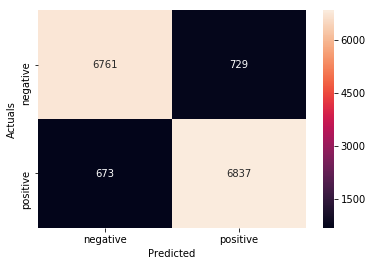

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      7490
    positive       0.90      0.91      0.91      7510

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000

